In [101]:
import io
import os
import zipfile
import pickle
from urllib.request import urlopen
from urllib.parse import urlparse

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [102]:
def fetch_speeches(years):
    paths = ['https://bis.org/speeches/speeches_' + str(year) + '.zip' for year in years]
    speeches = pd.DataFrame()

    for path in paths:
        remotezip = urlopen(path) # read the zip file as a string
        zipinmemory = io.BytesIO(remotezip.read()) # convert from a string to bytes
        zip = zipfile.ZipFile(zipinmemory) # pass the bytes to python's zipfile handler
        
        # read the excel spreadsheet
        xlsx_path = zip.namelist()[0] # get the name of the excel file
        with zip.open(xlsx_path) as f:
            data = pd.read_csv(f)

        data['id'] = [('').join(os.path.basename(urlparse(url).path).split('.')[:-1]) for url in data['url']]   
        speeches = pd.concat([speeches, data])
    return speeches

years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
        2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
        2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
data = fetch_speeches(years)


In [103]:
with open('parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [104]:
data = data.drop('text', axis=1)
data[0:2]

,url,title,description,date,author,id
0,https://www.bis.org/review/r970512a.pdf,Mr. Meyer discusses the economic outlook and t...,"Remarks by Mr. Laurence H. Meyer, a member of ...",1997-04-24 00:00:00,Laurence H Meyer,r970512a
1,https://www.bis.org/review/r970605b.pdf,Mr. Heikensten looks at the intellectual frame...,Address by the Deputy Governor of the Bank of ...,1997-05-26 00:00:00,Lars Heikensten,r970605b


In [105]:
def summation_score(classifier, weight):
   classifier[classifier > 0] *= weight
   try:
      score = sum(classifier) / len(classifier)
      return score
   except:
      return np.nan

scores = pd.DataFrame()
final_score = []
ids = []

weight = 1

for key in tqdm(parameters.keys()):
   ids.append(key)
   final_score.append( summation_score(np.array(parameters[key]), weight) )

scores['id'] = ids
scores['climatebert_scores'] = final_score

100%|██████████| 19160/19160 [00:00<00:00, 108414.16it/s]


In [106]:

data = pd.merge(data, scores, on='id')

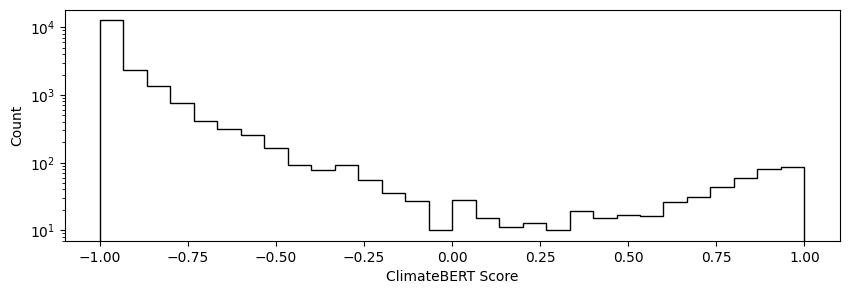

In [107]:
plt.figure(figsize=(10,3))
plt.hist(data['climatebert_scores'], color = 'k', histtype='step', bins=30)
plt.xlabel('ClimateBERT Score')
plt.ylabel('Count')
plt.yscale('log')

In [113]:
data.to_csv('all_data.csv')

In [109]:
climate_speeches = data[data['climatebert_scores'] > 1.5]
print(len(climate_speeches))

0


In [110]:
climate_speeches.head()

,url,title,description,date,author,id,climatebert_scores


In [111]:
parameters['r041122c']

array([ 1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1])

In [112]:
climate_speeches[['url', 'climatebert_scores']]

,url,climatebert_scores
